# DACSS 695M: Federal Criminal Sentencing Prediction

 In 2020, researchers released a dataset named [JUSTFAIR](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0241381#sec005): *Judicial System Transparency through Federal Archive Inferred Records*. This collection of data brings together sources from the US Sentencing Commission, the Federal Judicial Center, the PACER system, and Wikipedia to include over 500,000 federal criminal sentences, and background on each, including: Defendant demographics Nature of the crime, charges brought forward Judicial district, judge name Judge’s presidential appointment Judge’s educational background, work history Using 61 of the over 500 variables offered by JUSTFAIR, I have used machine learning techniques to create a method for predicting total sentencing in months as well as sentencing departures, e.g. if a sentence was adjusted to be either harsher or more forgiving based on the judge’s discretion.

There are only about [850](https://en.wikipedia.org/wiki/United_States_federal_judge#:~:text=the%20retirement%20benefit.-,Number%20of%20judges,the%20Court%20of%20International%20Trade.) federal judges in the U.S. at any given time, so this project could end up being a useful tool in the prediction of different permutations of defendant factors (i.e. race, criminal history, other demographics) for a particular court.

In [1]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import geopandas as gpd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')


In [2]:
justfair = pd.read_csv("justfair/FinalDataset.csv")
justfair_datadictionary = pd.read_csv("justfair/Data Dictionary.csv")

## Exploratory Data Analysis

For the most part, sentences stay relatively short: less than two years.

(0.0, 500.0)

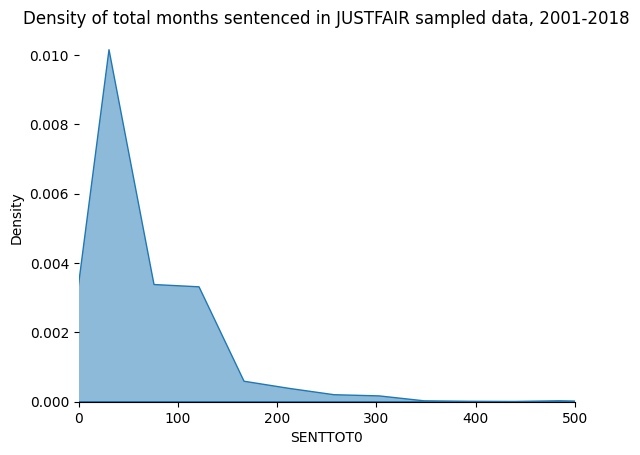

In [3]:
sns.kdeplot(data=justfair, x='SENTTOT0', fill=True, alpha=0.5)
sns.despine(left=True)

plt.title("Density of total months sentenced in JUSTFAIR sampled data, 2001-2018")
plt.xlabel("SENTTOT0")

# Set x-axis limits
plt.xlim(0, 500)

Probation is similarly low:

(0.0, 100.0)

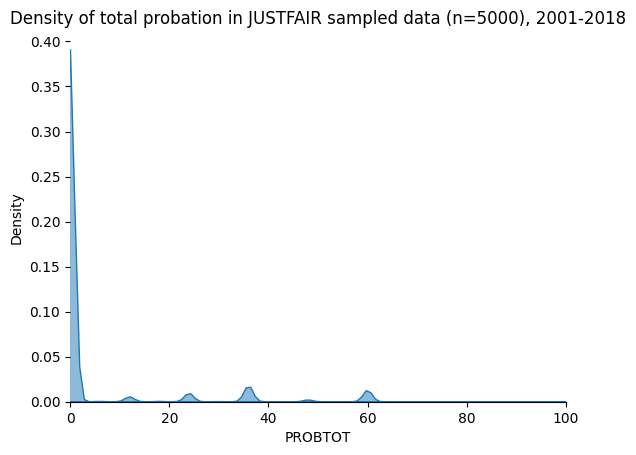

In [4]:
sns.kdeplot(data=justfair, x='PROBTOT', fill=True, alpha=0.5)
sns.despine(left=True)

plt.title("Density of total probation in JUSTFAIR sampled data (n=5000), 2001-2018")
plt.xlabel("PROBTOT")

# Set x-axis limits
plt.xlim(0, 100)

# Judicial Appointments

This project is mostly about prediction rather than inference, but I was initially curious about the difference between 'hard on crime' federal judges appointed during the Bush era and potentially more moderate judges during the Obama era. 

The data does not include many sentences from Trump appointments, which seemed like an interesting omission since it goes until 2018. From a relevant [Wikipedia](https://en.wikipedia.org/wiki/List_of_federal_judges_appointed_by_Donald_Trump) page, I found that most judges appointed by Trump did not begin active service until 2018, so that seems to explain it.

The visualizations below reflect only cases **in the JUSTFAIR dataset**, which contains data from 2001 to 2018. For that reason, the graphs should be regarded as a snapshot in time rather than accurate summary statistics about all judicial appointments to-date.

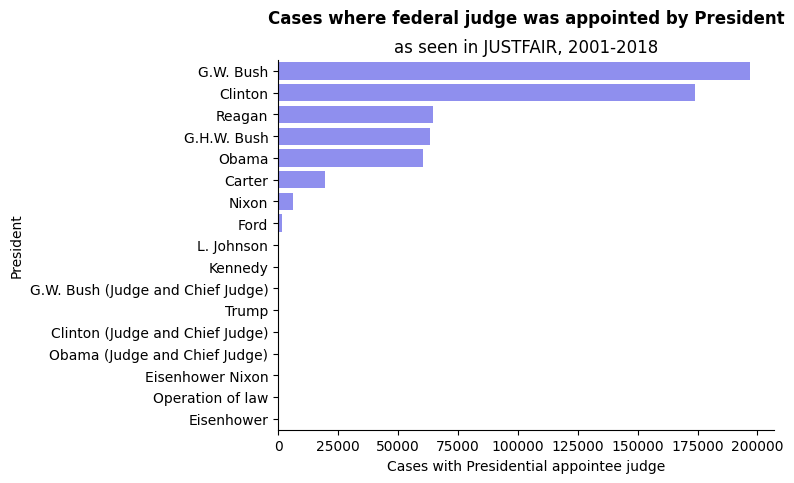

In [5]:
ax = sns.countplot(y='appointedby', data=justfair, color='blue', alpha=0.5, order=justfair['appointedby'].value_counts().index)
ax.set_xlabel('Cases with Presidential appointee judge')
ax.set_ylabel('President')
ax.set_title('as seen in JUSTFAIR, 2001-2018')
ax.text(0.5, 1.1, 'Cases where federal judge was appointed by President', transform=ax.transAxes,
        fontsize=12, fontweight='bold', ha='center')
sns.despine(top=True, right=True)
plt.show()


For example, the graph below shows a flurry of activity during the Bush years, but that is only because Bush's judges were in their prime working years during the time which this data was collected in:

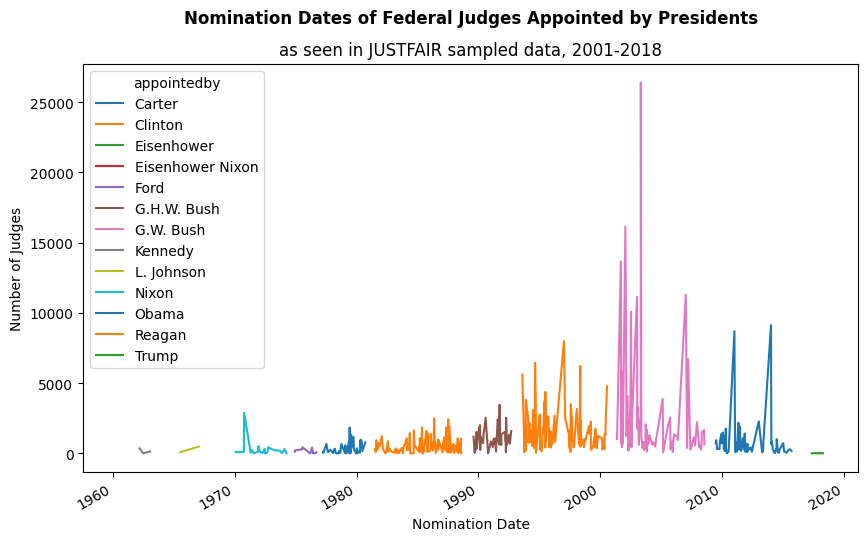

In [6]:
justfair['NominationDate1'] = pd.to_datetime(justfair['NominationDate1'])
counts = justfair.groupby(['NominationDate1', 'appointedby']).size().reset_index(name='count')
counts = counts.pivot(index='NominationDate1', columns='appointedby', values='count')
ax = counts.plot(figsize=(10,6))
ax.set_xlabel('Nomination Date')
ax.set_ylabel('Number of Judges')
# this is really a subtitle
ax.set_title('as seen in JUSTFAIR sampled data, 2001-2018')
# add actual title
ax.text(0.5, 1.1, 'Nomination Dates of Federal Judges Appointed by Presidents', transform=ax.transAxes,
        fontsize=12, fontweight='bold', ha='center')
plt.show()

As one can see, Republicans have had more judges working on cases in the period we are looking at:

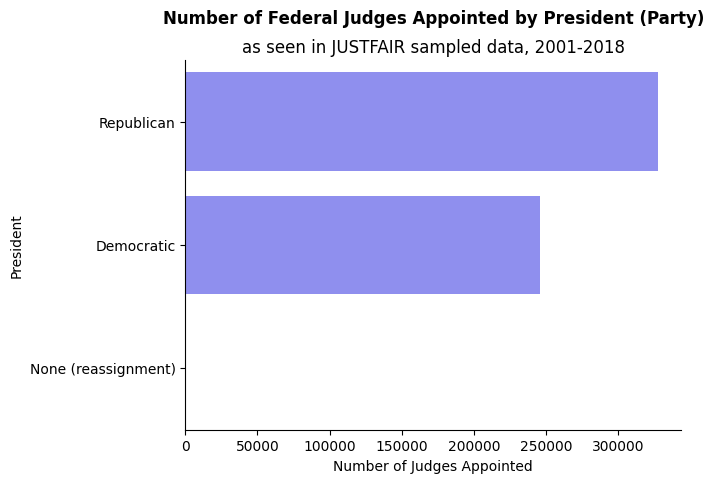

In [7]:
ax = sns.countplot(y='PartyofAppointingPresident1', data=justfair, color='blue', alpha=0.5, order=justfair['PartyofAppointingPresident1'].value_counts().index)
ax.set_xlabel('Number of Judges Appointed')
ax.set_ylabel('President')
ax.set_title('as seen in JUSTFAIR sampled data, 2001-2018')
ax.text(0.5, 1.1, 'Number of Federal Judges Appointed by President (Party)', transform=ax.transAxes,
        fontsize=12, fontweight='bold', ha='center')
sns.despine(top=True, right=True)
plt.show()

Just because I was curious, I did find that Republican sentences tended to be higher. This does not control for any confounding variables, however, and should not be regarded as a rigorous analysis:

In [8]:
dem_appointed_sentence_lengths = justfair[justfair['PartyofAppointingPresident1'] == 'Democratic']['SENTTOT0']
repub_appointed_sentence_lengths = justfair[justfair['PartyofAppointingPresident1'] == 'Republican']['SENTTOT0']

print("NAs found in Dem appointed sentence lengths: " , dem_appointed_sentence_lengths.isna().sum())
print("NAs found in Republican appointed sentence lengths: " , repub_appointed_sentence_lengths.isna().sum())

dem_appointed_sentence_lengths = dem_appointed_sentence_lengths.dropna()
repub_appointed_sentence_lengths = repub_appointed_sentence_lengths.dropna()

print("Results after NA removal: " , ttest_ind(dem_appointed_sentence_lengths, repub_appointed_sentence_lengths, equal_var=False))

NAs found in Dem appointed sentence lengths:  15373
NAs found in Republican appointed sentence lengths:  13750
Results after NA removal:  Ttest_indResult(statistic=-2.726967756472472, pvalue=0.006392148592284868)


# United States v. Booker

At this time, I think predicting sentence length is the best option for my project.

Still, after looking at the visualizations from the original [JUSTFAIR Tableau analysis](https://public.tableau.com/views/Book1_15950060723960/distxbookercdtbl?%3AshowVizHome=no), I have now come to think predicting values in the `BOOKER2` column in my data could be equally interesting. In simple terms, `BOOKER2` captures whether a criminal sentence is less or greater than the federal guidelines call for - based on the discretion of the judge.

Federal sentences at one time varied widely based on judge and district. After the [Sentencing Reform Act of 1984](https://en.wikipedia.org/wiki/Sentencing_Reform_Act#:~:text=The%20Sentencing%20Reform%20Act%2C%20part,the%20United%20States%20Sentencing%20Commission.), limits were placed on judicial discretion and uniform guidelines for criminal sentencing and probation were enacted by the [United States Sentencing Commision (USSC)](https://www.ussc.gov/).

Yet, they were loosened again in Koon v. United States (1996), a Supreme Court case which affirmed light sentences given to two policemen convicted of beating [Rodney King](https://www.npr.org/2017/04/26/524744989/when-la-erupted-in-anger-a-look-back-at-the-rodney-king-riots), an event which precipitated the 1992 Los Angeles riots.

In 2005, [United States v. Booker](https://www.oyez.org/cases/2004/04-104) re-imposed limitations on judicial discretion, requiring the legal facts considered for sentence enhancement to be explicitly spelled out in the defendant's guilty plea or otherwise contained in the legal record. The Supreme Court found that allowing otherwise - i.e., allowing judges to increase sentences based on facts not reviewed by juries  - would violate the Sixth Amendment. 

In our data, `BOOKER2` describes whether a sentence falls into one of four categories:

`Within Range` - Within normal guidelines prescribed by the USSC (mandatory minimums, etc.)

`Above Departure` - Sentences *increased* due to judicial discretion.

`Government Sponsored Below Range` - Sentences *decreased*  due to the defendent cooperating with prosecutors

`Below Range` - Sentences *decreased*  due to judicial discretion.

This graph shows the distribution of these categories:

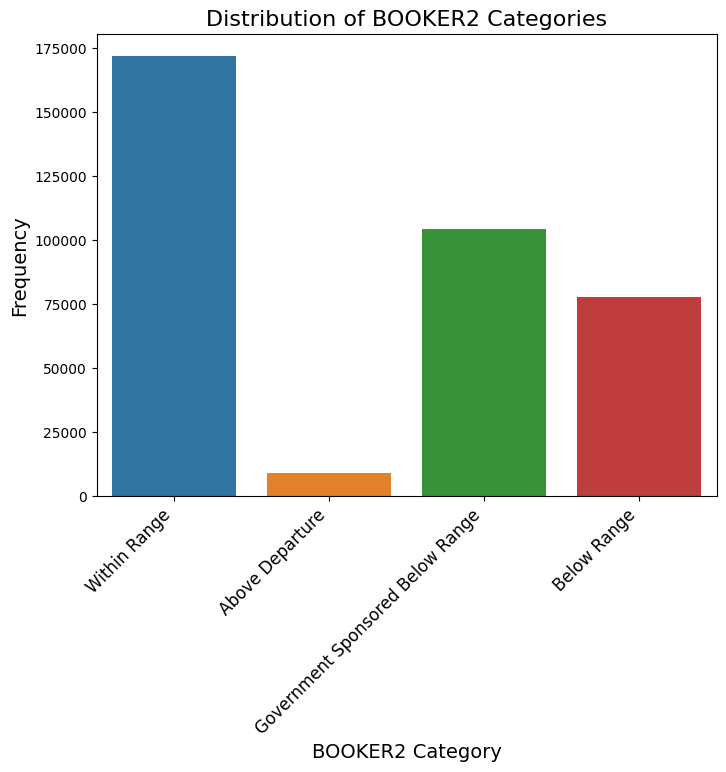

In [9]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='BOOKER2', data=justfair)
ax.set_title('Distribution of BOOKER2 Categories', fontsize=16)
ax.set_xlabel('BOOKER2 Category', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xticklabels(['Within Range', 'Above Departure', 'Government Sponsored Below Range', 'Below Range'], fontsize=12, rotation=45, ha='right')
plt.show()

#### What does 'Government Sponsored Below Range' mean?

These values can fall into a few categories:

`5K1.1/Substantial Assistance`: This applies in cases where the defendant has cooperated in providing information leading to the prosecution of another person or organization.

`6 = Early Disposition/5K3.1`: An early guilty plea, helping the justice system avoid a lengthy trial.

`7 = Government Sponsored`: A case where an individual broke the law on behalf of the government - for example, an undercover agent.

### Sentencing after Booker

Part of United States v. Booker's significance was that it could lead to less racial bias according to sentencing. Unfortunately, even the USSC's [own analysis](https://www.ussc.gov/research/research-publications/demographic-differences-federal-sentencing-practices-update-booker-reports-multivariate-analysis) shows that disparities remain:

Among its findings (quoted here directly):

>*"This report focused on three separate time periods which together spanned the time between May 1, 2003, and September 30, 2009. The Commission found a correlation between the length of sentences imposed on some groups of offenders and the demographic characteristics of those offenders"*
>
>- *Black male offenders received longer sentences than white male offenders. The differences in sentence length have increased steadily since Booker.*
>
> - *Female offenders of all races received shorter sentences than male offenders. The differences in sentence length fluctuated at different rates in the time periods studied for white females, black females, Hispanic females, and “other” female offenders (such as those of Native American, Alaskan Native, >and Asian or Pacific Islander origin).*
>
> - *Non-citizen offenders received longer sentences than offenders who were U.S. citizens. The differences in sentence length have increased steadily since >Booker.*
>
> - *Offenders with some college education received shorter sentences than offenders with no college education. The differences in sentence length have >remained relatively stable across the time periods studied.* 
> 
> - *The data were inconsistent as to the association between an offender’s age and the length of sentence imposed.*

### Visualizing Booker categories by race

Since the beginning of Booker categories, people have been interested in the differences in 'harshness' based on race:

In [10]:
race_labels = {
    1: 'White',
    2: 'Black',
    3: 'Hispanic',
    6: 'Other'
}

justfair['NEWRACE'] = justfair['NEWRACE'].map(race_labels)

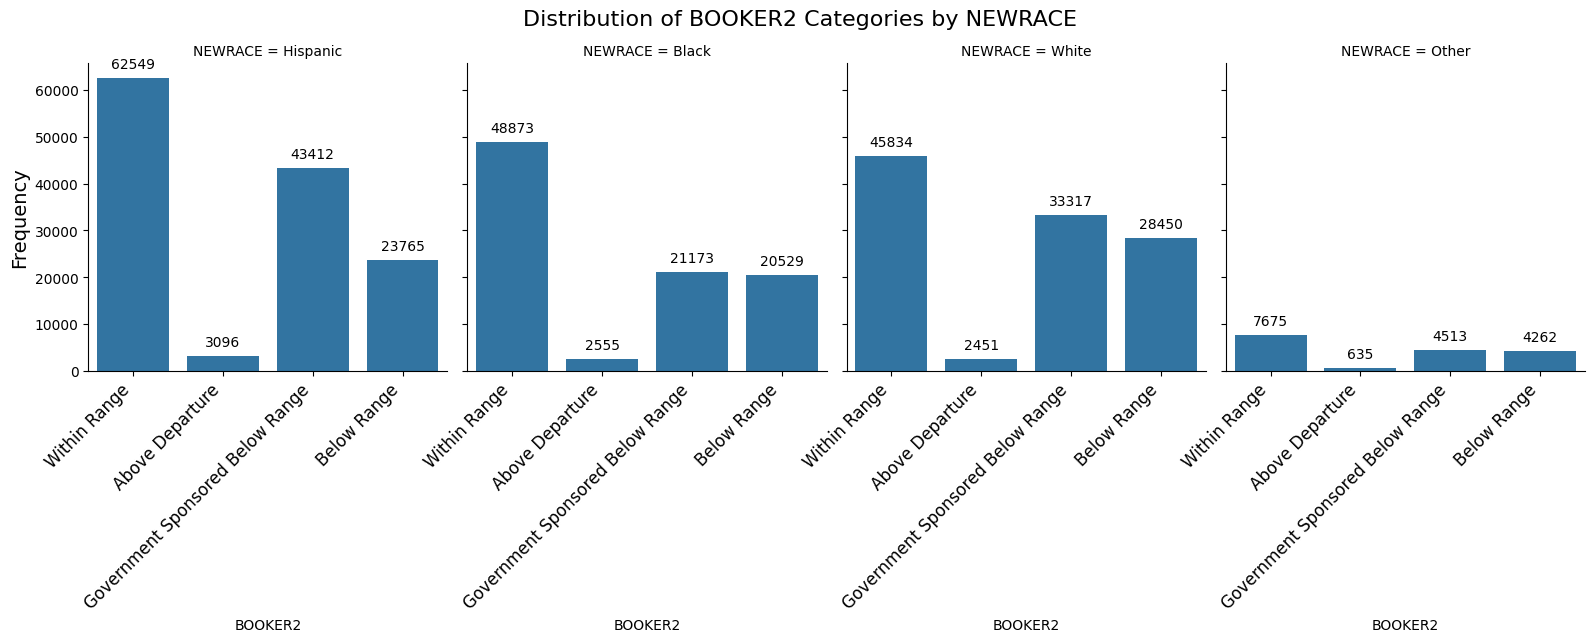

In [11]:
g = sns.FacetGrid(data=justfair, col='NEWRACE', height=4)
g.map(sns.countplot, 'BOOKER2')
g.fig.suptitle('Distribution of BOOKER2 Categories by NEWRACE', fontsize=16, y=1.05)
g.set_ylabels('Frequency', fontsize=14)
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
for ax in g.axes.flat:
    ax.set_xticklabels(['Within Range', 'Above Departure', 'Government Sponsored Below Range', 'Below Range'], fontsize=12, rotation=45, ha='right')
plt.show()

Examining the chart above, one can see that white defendants are more likely to have a `Below Range` adjustment to their sentencing, while the opposite is observed for hispanics.

This stacked bar chart shows that in a different way:

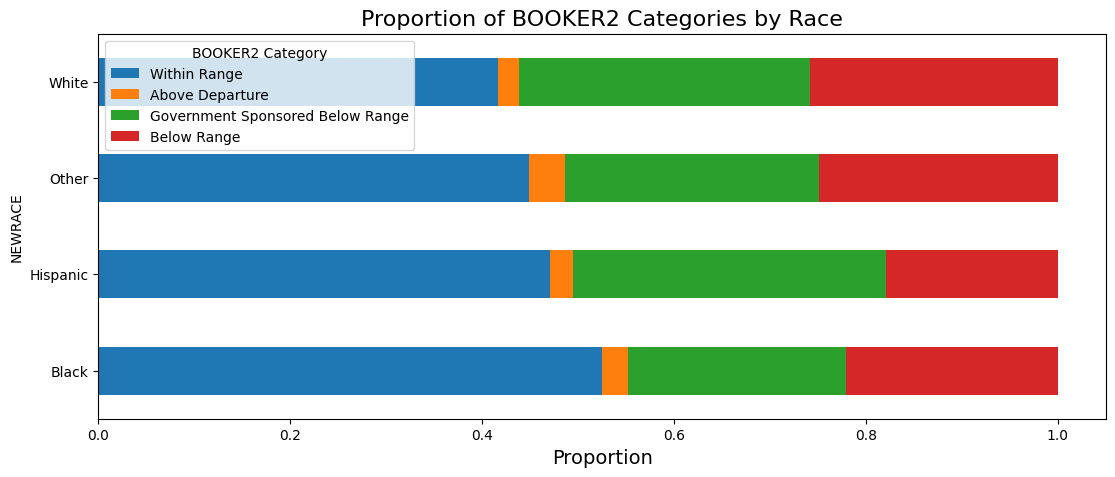

In [12]:

category_labels = ['Within Range', 'Above Departure', 'Government Sponsored Below Range', 'Below Range']
race_counts = justfair.groupby('NEWRACE')['BOOKER2'].value_counts(normalize=True).unstack()
race_counts.plot(kind='barh', stacked=True, figsize=(13, 5))
plt.title('Proportion of BOOKER2 Categories by Race', fontsize=16)
plt.xlabel('Proportion', fontsize=14)
plt.legend(title='BOOKER2 Category', labels=category_labels)
# Show the plot
plt.show()


\* This plot is similar to one found on the JUSTFAIR [Tableau page](https://public.tableau.com/views/Book1_15950060723960/Story1?%3AshowVizHome=no)

# Districts

The data inside the `justfair` .csv is numerically encoded. Please forgive the long dicts that are necessary to transalte into meaninful data for visualization.

In [13]:
district_state_names = {
'1': 'District of Columbia',
'2': 'Maine',
'3': 'Massachusetts',
'4': 'New Hampshire',
'5': 'Puerto Rico',
'6': 'Rhode Island',
'7': 'Connecticut',
'8': 'New York',
'9': 'New York',
'10': 'New York',
'11': 'New York',
'12': 'Vermont',
'13': 'Delaware',
'14': 'New Jersey',
'15': 'Pennsylvania',
'16': 'Pennsylvania',
'17': 'Pennsylvania',
'18': 'Virgin Islands',
'19': 'Maryland',
'20': 'North Carolina',
'21': 'North Carolina',
'22': 'North Carolina',
'23': 'South Carolina',
'24': 'Virginia',
'25': 'Virginia',
'26': 'West Virginia',
'27': 'West Virginia',
'28': 'Louisiana',
'29': 'Louisiana',
'30': 'Louisiana',
'31': 'Mississippi',
'32': 'Mississippi',
'33': 'Texas',
'34': 'Texas',
'35': 'Texas',
'36': 'Texas',
'37': 'Kentucky',
'38': 'Kentucky',
'39': 'Michigan',
'40': 'Michigan',
'41': 'Ohio',
'42': 'Ohio',
'43': 'Tennessee',
'44': 'Tennessee',
'45': 'Tennessee',
'46': 'Illinois',
'47': 'Illinois',
'48': 'Illinois',
'49': 'Indiana',
'50': 'Indiana',
'51': 'Wisconsin',
'52': 'Wisconsin',
'53': 'Arkansas',
'54': 'Arkansas',
'55': 'Iowa',
'56': 'Iowa',
'57': 'Minnesota',
'58': 'Missouri',
'59': 'Missouri',
'60': 'Nebraska',
'61': 'North Dakota',
'62': 'South Dakota',
'63': 'Alaska',
'64': 'Arizona',
'65': 'California',
'66': 'California',
'67': 'California',
'68': 'California',
'69': 'Guam',
'70': 'Hawaii',
'71': 'Idaho',
'72': 'Montana',
'73': 'Nevada',
'74': 'Commonwealth of the Northern Mariana Islands',
'75': 'Oregon',
'76': 'Washington',
'77': 'Washington',
'78': 'Colorado',
'79': 'Kansas',
'80': 'New Mexico',
'81': 'Oklahoma',
'82': 'Oklahoma',
'83': 'Oklahoma',
'84': 'Utah',
'85': 'Wyoming',
'86': 'Alabama',
'87': 'Alabama',
'88': 'Alabama',
'89': 'Florida',
'90': 'Florida',
'91': 'Florida',
'92': 'Georgia',
'93': 'Georgia',
'94': 'Georgia'}

justfair['CIRCDIST_NAME_COMMON'] = justfair['CIRCDIST'].astype(str).map(district_state_names)

Here we find the median sentence length by state - it seems like the midwest is leading the pack:

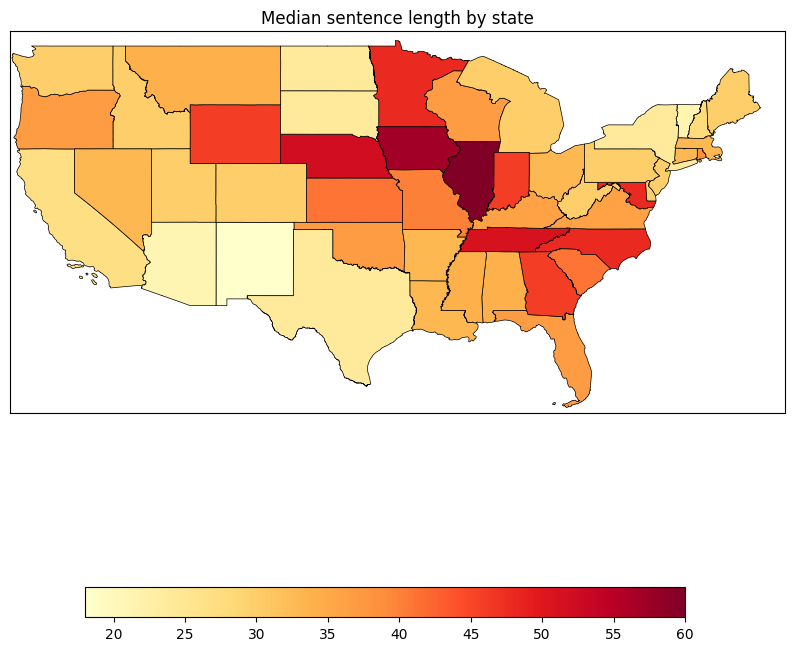

In [14]:
us_map = gpd.read_file('justfair/USA_adm1.shp')
grouped = justfair.groupby('CIRCDIST_NAME_COMMON')['SENTTOT0'].median()
merged = us_map.merge(grouped, how='left', left_on='NAME', right_on='CIRCDIST_NAME_COMMON')
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='SENTTOT0', cmap='YlOrRd', linewidth=0.5, edgecolor='black', ax=ax)
ax.set_title('Median sentence length by state')
ax.set_xticks([])
ax.set_yticks([])
cax = fig.add_axes([0.2, 0.1, 0.6, 0.03])
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=merged['SENTTOT0'].min(), vmax=merged['SENTTOT0'].max()))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
ax.set_xlim([-125, -65])
ax.set_ylim([24, 50])
plt.show()


And compare with above-average sentencing departures a la Booker:

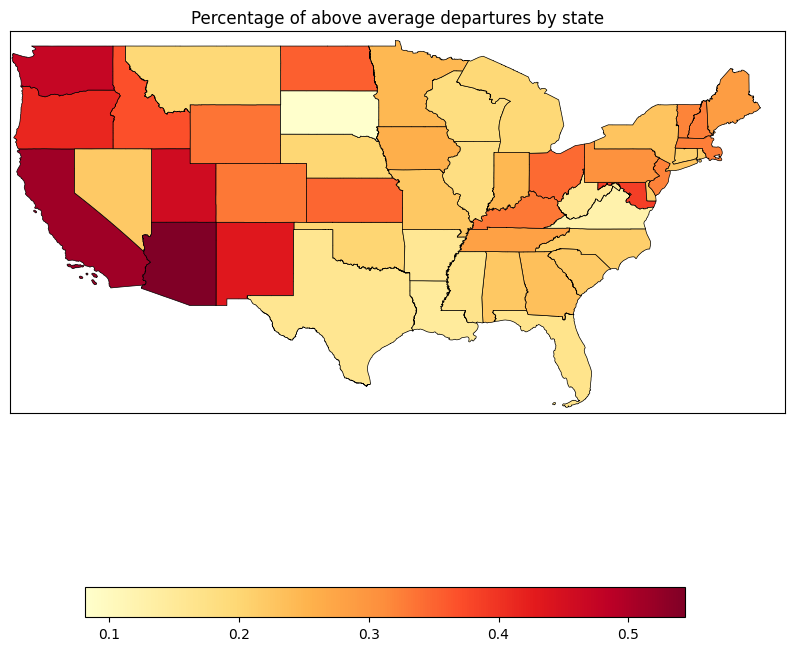

In [15]:
grouped = justfair[justfair['BOOKER2'] == 2].groupby('CIRCDIST_NAME_COMMON')['BOOKER2'].count() / justfair.groupby('CIRCDIST_NAME_COMMON')['BOOKER2'].count()
merged = us_map.merge(grouped, how='left', left_on='NAME', right_on='CIRCDIST_NAME_COMMON')
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='BOOKER2', cmap='YlOrRd', linewidth=0.5, edgecolor='black', ax=ax)
ax.set_title('Percentage of above average departures by state')
ax.set_xticks([])
ax.set_yticks([])
cax = fig.add_axes([0.2, 0.1, 0.6, 0.03])
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=merged['BOOKER2'].min(), vmax=merged['BOOKER2'].max()))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
ax.set_xlim([-125, -65])
ax.set_ylim([24, 50])
plt.show()


Remember that these are federal courts - not state courts. So they only have jurisdiction over certain types of cases (although there is some overlap).

Federal cases are not necessarily more serious, but they are often more complex and carry different sentences that state crimes.

### Sentencing Guidelines

As said, the USSC publishes official [guidelines for criminal offences](https://www.ussc.gov/guidelines/2021-guidelines-manual/annotated-2021-chapter-2-c). The actual sections of the law can be found in our data:

In [16]:
# https://www.ussc.gov/guidelines/2021-guidelines-manual/annotated-2021-chapter-2-c
justfair['GDLINEHI'].unique()

array(['2L1.2', '2B1.1', '2D1.1', '2D2.2', '2G2.2', nan, '2B3.1', '2T1.1',
       '2S1.1', '2A3.1', '2C1.3', '2K2.1', '2C1.1', '2T1.6', '2Q1.2',
       '2A6.1', '2C1.2', '2E5.1', '2J1.6', '2P1.1', '2A4.1', '2G1.3',
       '2L2.2', '2J1.2', '2D2.1', '2A2.4', '2A3.5', '2N2.1', '2T3.1',
       '2J1.7', '2G2.4', '2L2.1', '2A2.1', '2D1.2', '2D1.8', '2S1.3',
       '2C1.8', '2J1.4', '2M3.2', '2T1.4', '2M5.2', '2B5.3', '2G2.1',
       '2B2.3', '2X1.1', '2K2.5', '2F1.1', '2C1.7', '2G1.1', '2B1.3',
       '2A2.2', '2L1.1', '2M5.1', '2A2.3', '2B3.3', '2H1.1', '2B2.1',
       '2A3.4', '2B5.1', '2X3.1', '2M3.1', '2K1.5', '2B4.1', '2A1.1',
       '2R1.1', '2X5.2', '2M5.3', '2X4.1', '2M6.1', '2K2.6', '2Q1.3',
       '2A1.5', '2A1.2', '2J1.3', '2B3.2', '2E1.4', '2A1.3', '2K1.3',
       '2K1.4', '2A6.2', '2C1.4', '2A3.2', '2A4.2', '2E2.1', '2Q2.1',
       '2D1.5', '2B6.1', '2E3.1', '2T1.9', '2H3.3', '2D3.1', '2N1.1',
       '2P1.2', '2A5.2', '2G3.1', '2H3.1', '2E4.1', '2B1.4', '2F1.2',
       '2M3.3',

However, there is also a [Codebook](https://www.ussc.gov/sites/default/files/pdf/research-and-publications/datafiles/USSC_Public_Release_Codebook_FY99_FY21.pdf) that explains a simplified type of offense:

In [17]:
offtype_dict = {
    '1.0': 'Murder',
    '2.0': 'Manslaughter',
    '3.0': 'Kidnapping/Hostage Taking',
    '4.0': 'Sexual Abuse',
    '5.0': 'Assault',
    '6.0': 'Robbery',
    '9.0': 'Arson',
    '10.0': 'Drugs - Trafficking, Manufacturing, and Importing',
    '11.0': 'Drugs - Communication Facilities',
    '12.0': 'Drugs: - Simple Possession',
    '13.0': 'Firearms (Includes Firearms Use, Possession, and Trafficking)',
    '15.0': 'Burglary/Breaking and Entering',
    '16.0': 'Auto Theft',
    '17.0': 'Larceny',
    '18.0': 'Fraud',
    '19.0': 'Embezzlement',
    '20.0': 'Forgery/Counterfeiting',
    '21.0': 'Bribery',
    '22.0': 'Tax Offenses',
    '23.0': 'Money Laundering',
    '24.0': 'Racketeering /Extortion',
    '25.0': 'Gambling/Lottery',
    '26.0': 'Civil Rights Offenses',
    '27.0': 'Immigration',
    '28.0': 'Pornography/Prostitution (Value not available after FY2009)',
    '29.0': 'Prison Offenses',
    '30.0': 'Administration of Justice',
    '31.0': 'Environmental, Game, Fish, and Wildlife Offenses',
    '32.0': 'National Defense Offenses',
    '33.0': 'Antitrust Violations',
    '34.0': 'Food and Drug Offenses',
    '35.0': 'Traffic Violations and Other Offenses',
    '42.0': 'Child Pornography (Value not available prior FY2010)',
    '43.0': 'Obscenity (Value not available prior FY2010)',
    '44.0': 'Prostitution (Value not available prior FY2010)',
    '.': 'Missing'
}

justfair['OFFTYPE2_NAME'] = justfair['OFFTYPE2'].astype(str).map(offtype_dict)

Here is the breakdown of sentence lengths by offense type:

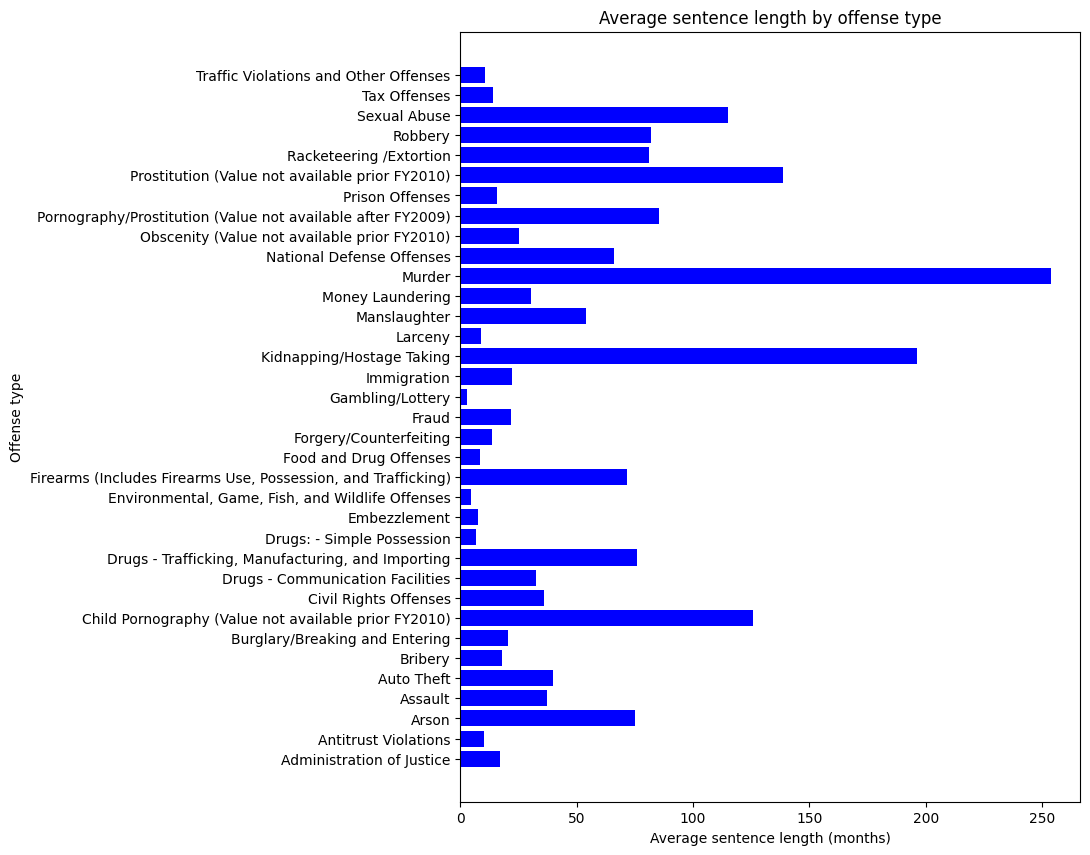

In [18]:
grouped = justfair.groupby('OFFTYPE2_NAME')['SENTTOT0'].mean()
fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(y=grouped.index, width=grouped.values, color='blue')
ax.set_title('Average sentence length by offense type')
ax.set_xlabel('Average sentence length (months)')
ax.set_ylabel('Offense type')
plt.show()


# Prediction

### Thinking temporally

Each row in this dataset is a court case that has been completed, and this brings the opportunity of doing supervised learning with all of that infomation. 

On the other side of that coin, we are dealing with some information that would naturally only be available after the outcome (i.e. sentencing) is reached.

If we develop a tool, it should be useful to either attorneys or the public. Therefore we should keep in mind the availability (or lack therof) of information during [each stage of the federal criminal process ](https://www.justice.gov/usao/justice-101/steps-federal-criminal-process).

| Stage | Description |
|-------|-------------|
|**Investigation**|The FBI, DEA, ATF, or another agency collects information about the suspect. Direct and circumstantial evidence is collected.|
|**Charging**|A prosecutor reviews information from investigators and decides to present the case to a grand jury (in the case of a felony). If indicted, the suspect is notified so. A defense attorney is usually hired, or a public defender is brought on.|
|**Initial Hearing / Arraignment**|The defendant is brought before a magistrate judge who decides if they will be held in prison or released until the trial. The judge can make a decision on whether to grant bail based on background facts about the defendant.|
|**Discovery**|Both the prosecutor and defense are talking to witnesses - lay, expert, and character. The prosecutors provide the defendant with information they intend to use at trial, and this continues until the end of the case. The prosecution is required to include exculpatory evidence.|
|**Plea Bargaining**|If the prosecution has a strong case, a plea bargain is offered to avoid a more lengthy sentence. A huge percentage of cases skip to sentencing from here.|
|**Preliminary Hearing**|If a not guilty plea is submitted, this is a first 'mini-trial'. Witnesses and evidence are introduced by the prosecution without the defense being able to suppress it. A judge decides if there is probable cause, and if so, the case proceeds. If not, the charges are dismissed.|
|**Pre-Trial Motions**|The prosecutor or defense can file motions to dismiss the case, to suppress statements or evidence, or to change the venue of the trial.|
|**Trial**|First, 12 jurors are selected randomly from the jury pool. A judge is supposed to keep an eye out discrimination based on demographic or affiliation. Both the prosecution and defense are allowed to excuse a limited number jurors without providing a reason, and jurors can also be excused after questioning reveals bias. The trial proceeds - details omitted - and a verdict is reached by the jury.|
|**Post-Trial Motions**|The defense may move for a new trial, acquittal, or to correct a clerical error in the sentence.|
|**Sentencing**|The defendant, after being found guilty, returns to court a few months later for sentencing. Minimum and maximum penalties by the USSC are observed, but the judge applies them and wields a lot of discretion in doing so. Aggravating or mitigating factors like recidivism and family life are considered.|
|**Appeal**|Here, the case may be reversed if it can be proven that the judge acted incorrectly or a sentence was too harsh. Sometimes cases go back to trial, or even to the Supreme Court. |

 ## Availability of variables by stage
With over 500 columns, the `JUSTFAIR` data is difficult to think through in respect to availability of information over time. Instead of going through each column, I think the best approach is to think intuitively about what kind of information a lawyer would have in advance for each column. This is a first pass at what I think a defense attorney could reasonably infer or have access to, depending on circumstances.

Descriptions are taken directly from the JUSTFAIR data dictionary:


**Charging**

| Variable | Description |
| --- | --- |
 DRUGTYP1 | Drug types involved in a case.
 COMBDRG2 | Aggregation of DRUGTYP1 for USSC Sourcebook tables.
 NEWRACE | Race of defendant (Recode of MONRACE and HISPORIG for the annual report).
 AGE | "Identifies the age of the defendant at the time of sentencing. It is generated based on the date of birth provided either in the PSR or    at case submission to USSC  and the sentencing date from the J&C."
 MONSEX | Indicates the offender's gender.
 CITWHERE | Identifies the defendant's country of citizenship. - or - 
 NEWCIT | Citizenship of the defendant.
 CRIMHIST | "Indication as to whether the defendant has any criminal history or law enforcement contacts , including behavior that is not   eligible for the application of criminal history points (ex. arrests)."
 EDUCATN | Indicates the highest level of education completed by the defendant.
 ENCRYPT1 | Indicates if case contained any occurrences of use of encryption or scrambling technology to obstruct justice.
 POINT1 | Number of one-point incidents (sentences < 60 days) included in the criminal history section of the PSR.
 POINT2 | Number of two-point incidents (> 60 days and < 13 months) included in the criminal history section of the PSR.
 POINT3 | Number of three-point incidents (> 13 months) included in the criminal history section of the PSR.
 PRESENT | Offender’s pre-sentence detention status.
 UNIT1 | The unit of measure for the first through nth drug types (DRUGTYP1- DRUGTYPX) and amount (DRGAM1- DRGAMX) for which the defendant was held responsible.
 DRUGMIN | Represents mandatory minimum sentence (in months) associated with drug statutes.
 STATMAX | "Total statutory maximum prison term,  in months,  for all counts."
 STATMIN | "Total statutory minimum prison term,  in months,  for all counts of conviction."
 GDLINEHI | The Chapter Two Guideline applied in a case. 
 GDSTATHI | The Chapter Two Guideline applied in a case. 
 OFFTYPE2 | "Primary offense type for the case generated from the count of conviction with the highest statutory maximum (in case of a tie the count with the highest statutory minimum is used)."
 FCOUNSEL | A code indicating the type of legal counsel assigned to a defendant
 FTITLE1 | The title and section of theU.S. Code applicable to the offense committed whichcarried the highest severity
 FOFFLVL1 | A code indicating the level of offense associated withFTITLE1
 FTITLE2 | The title and section of theU.S. Code applicable to the offense committed which carried the second highestseverity
 FOFFLVL2 | A code indicating the level of offense associated withFTITLE2
 FTITLE3 | The title and section of theU.S. Code applicable to the offense committed which carried the third highestseverity
 FSEV3 | A code indicating the severityassociated with FTITLE3
 FTITLE4 | The title and section of theU.S. Code applicable to the offense committed which carried the fourth highestseverity
 FSEV4 | A code indicating the severityassociated with FTITLE4
 TTITLE1 | The title and section of theU.S. Code applicable to the offense that carried the most severe disposition and penalty under which thedefendant was disposed
 TOFFLVL1 | A code indicating the level of offense associated withTTITLE1
 TSEV1 | A code indicating the severityassociated with TTITLE1


**Initial Hearing / Arraignment**: 
| Variable | Description |
| --- | --- |
| CIRCDIST | Districts in the order in which they appear in the Commission’s Sourcebook of Federal Sentencing Statistics.
| CIRCUIT | The code of the federal judicial circuit where the casewas located
| judge | Judge name as extracted from Wikipedia court district pages. 
| dutystation | Duty station that the federal judge serves at.
| active | Judge activity period
| Gender | Judge gender. 
| RaceorEthnicity | Judge race or ethnicity.
| PartyofAppointingPresident1 | Party of Appointing President. 
| AppointingPresident1 | U.S. President that appointed the federal judge (FJC). 
| ABARating2 | American Bar Association evaluation of professional qualifications. 
| School1 | School (university) attended. 
| School2 | School (university) attended. 
| School3 | School (university) attended. 

**Plea Bargaining**:
| Variable | Description |
| --- | --- |
 NEWCNVTN | Indicates whether the case was settled by plea agreement or trial.

**Post-Trial Motions**:
| Variable | Description |
| --- | --- |
STATMAX | "Total statutory maximum prison term in months for all counts."
STATMIN | "Total statutory minimum prison term in months for all counts of conviction." 
TIMSERVD | This is the amount of time already served (in days) and credited to the offender by the judge at the time of sentencing.
TIMSERVM | This is the amount of time already served (in months) and credited to the offender by the judge at the time of sentencing.

**Sentencing**:
| Variable | Description |
| --- | --- |
| SENTTOT0 | The total prison sentence (excluding months of alternative confinement),  in months , with zeros (probation). Missing cases are set to ""·"".  This field includes sentences of time imposed,  time served, and §5G1.3 credit."
| STATMAX | Total statutory maximum prison term  in months  for all counts."
| STATMIN | Total statutory minimum prison term  in months  for all counts of conviction." 
| ALTDUM | "Dummy indicator of alternative sentence (home detention  community confinement  or intermittent confinement)  as defined in §5C1.1."
| ALTMO | "Total months of alternative incarceration (includes home detention community confinement and intermittent confinement)."
| COMDUM | Indicator as to whether the defendant received community confinement.
| COSTSDUM | Indicator of whether the cost of supervision is given (YES/NO variable).
| HOMDUM | Indicates whether the defendant received home detention.
| HRCOMSRV | Total number of community service hours ordered.
| NOCOMP | The number of guideline computations.
| NOCOUNTS | The number of counts of conviction.
| PRISDUM | Indicates if the defendant received a prison sentence (YES/NO variable).
| TOTCHPTS | The total number of criminal history points applied.
| WEAPON | Indicates if there is an SOC weapon enhancement or an 18§924(c) conviction.
| VIOL1PTS | Number of criminal history points applied for each prior sentence resulting from a conviction of a crime of violence that did not already receive points under  §§4A1.
| ADJOFL1 | This field is the adjusted offense level.
| ADJOFLHI | This field is the adjusted offense level.
| BOOKER2 | Assigns cases to one of the 12 post-Booker reporting categories based on relationship between the sentence and guideline range and the reason(s) given for being outside of the range.

Next, I'll make arrays so those variables can easily be called on:

In [19]:
charging_predictors = ["DRUGTYP1", "COMBDRG2", "NEWRACE", "AGE", "MONSEX", "CITWHERE", "NEWCIT", "CRIMHIST", "EDUCATN", "ENCRYPT1", "POINT1", "POINT2", "POINT3", "PRESENT", "UNIT1", "DRUGMIN", "STATMAX", "STATMIN", "GDLINEHI", "GDSTATHI", "OFFTYPE2", "FCOUNSEL", "FTITLE1", "FOFFLVL1", "FTITLE2", "FOFFLVL2", "FTITLE3", "FSEV3", "FTITLE4", "FSEV4", "TTITLE1", "TOFFLVL1", "TSEV1"]
hearing_predictors = ["CIRCDIST",  "CIRCUIT",  "judge",  "dutystation",  "active",  "Gender",  "RaceorEthnicity",  "PartyofAppointingPresident1",  "AppointingPresident1",  "ABARating2",  "School1",  "School2",  "School3"]
plea_predictors = ["NEWCNVTN"]
sentencing_predictors = ["ALTDUM", "ALTMO", "COMDUM", "COSTSDUM", "HOMDUM", "HRCOMSRV", "NOCOMP", "NOCOUNTS", "PRISDUM", "TOTCHPTS", "WEAPON", "VIOL1PTS", "ADJOFL1", "ADJOFLHI"]

all_predictors = charging_predictors + hearing_predictors + plea_predictors + sentencing_predictors

#### JUSTFAIR limitations

Here is another important thing to remember: **99% of those who are charged by the federal government end up** [**convicted and sentenced**](https://www.nydefensecounsel.com/do-federal-cases-ever-get-dismissed/#:~:text=97%25%20of%20federal%20defendants%20plead,are%20ultimately%20convicted%20and%20sentenced.). Generally, the government does not bring a suit unless they see a high chance of winning it.

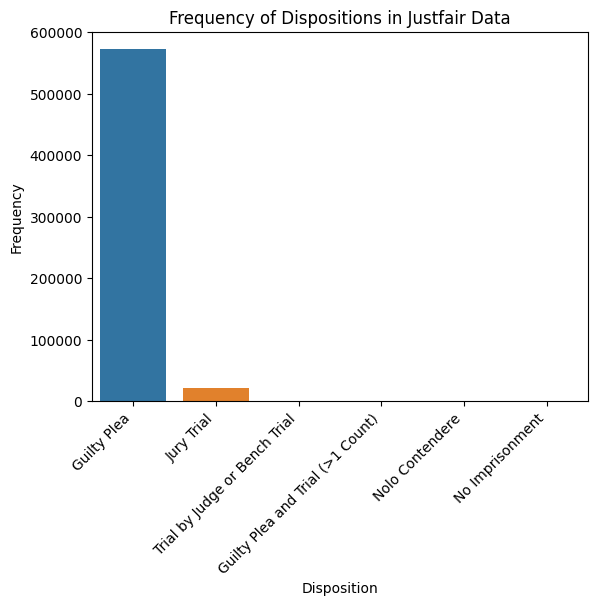

In [20]:
disposit_dict = {
    0: 'No Imprisonment',
    1: 'Guilty Plea',
    2: 'Nolo Contendere',
    3: 'Jury Trial',
    4: 'Trial by Judge or Bench Trial',
    5: 'Guilty Plea and Trial (>1 Count)'
}

justfair['DISPOSIT'] = justfair['DISPOSIT'].map(disposit_dict)
disposition_counts = justfair['DISPOSIT'].value_counts()

sns.barplot(x=disposition_counts.index, y=disposition_counts.values)

plt.title('Frequency of Dispositions in Justfair Data')
plt.xlabel('Disposition')
plt.ylabel('Frequency')

plt.xticks(rotation=45, ha='right')

plt.show()

Additionally, **the JUSTFAIR data only includes information about defendants who end up being sentenced**. It does not include any cases where the case was dismissed or the defendent was not sentenced.  That is because it comes from USSC data, an organization which - necessarily - is just concerned with sentencing.

Considering the percent of cases that are not aquitted, we are not missing much with this limitation. However, it does mean that a machine learning model will be 'learning' only about the 'losers' of federal cases, i.e. those whose lawyers did not succeed in having their case dismissed. 

Perhaps there is better information somewhere in a dataset of cases that did *not* go to trial. But still, a defense lawyer could still achieve a measure of success if she or he could reduce the sentence as compared with other similar cases. Therefore I think it is still worthwhile to predict sentencing based on available factors.

## Data Preprocessing

In [21]:
# split data into train and validation sets
train_set, validation_set = train_test_split(justfair, test_size=0.3, random_state=1)

In [22]:
random.seed(1)
train_set_sampled = train_set.sample(n=10000)

In [23]:
charging_predictors_categorical = ['DRUGTYP1', 'COMBDRG2', 'CITWHERE', 'NEWRACE', 'NEWCIT', 'CRIMHIST', 'EDUCATN', 'ENCRYPT1', 'PRESENT','UNIT1','GDLINEHI','GDSTATHI','OFFTYPE2','FCOUNSEL', 'FTITLE1', 'FTITLE2', 'FTITLE3', 'FTITLE4', 'TTITLE1', 'FSEV3', 'FSEV4', 'TSEV1']
hearing_predictors_categorical = ['CIRCDIST', 'CIRCUIT', 'judge', 'dutystation', 'active', 'Gender', 'RaceorEthnicity', 'PartyofAppointingPresident1', 'AppointingPresident1', 'ABARating2', 'School1', 'School2', 'School3']
sentencing_predictors_categorical = ['COSTSDUM', 'HOMDUM', 'PRISDUM', 'WEAPON', 'ADJOFL1', 'ADJOFLHI']
all_predictors_categorical = charging_predictors_categorical + hearing_predictors_categorical + sentencing_predictors_categorical

In [24]:
def correlation_graph (input):
    # Select only numeric columns from input
    numeric_cols = input.select_dtypes(include=np.number)
    
    # Compute the correlation matrix
    corr = numeric_cols.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, annot=False)

Let's visualize the variables we can use at different stages. Here are just the charging predictors:

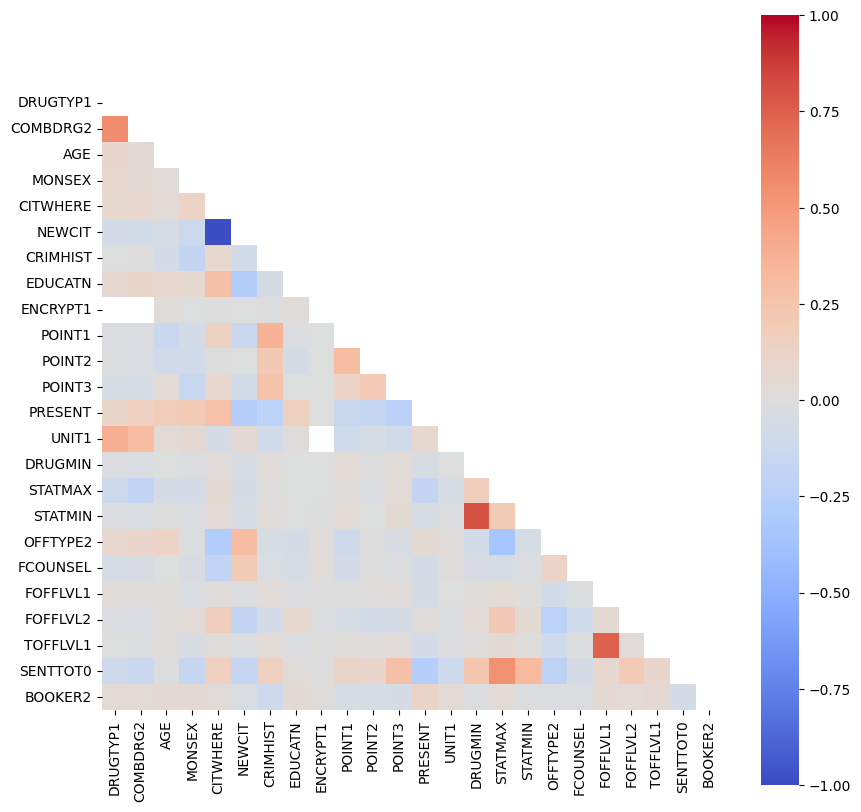

In [25]:
correlation_graph(train_set_sampled[charging_predictors + ['SENTTOT0', 'BOOKER2']])

And here, at a later stage, are the charging + hearing predictors:

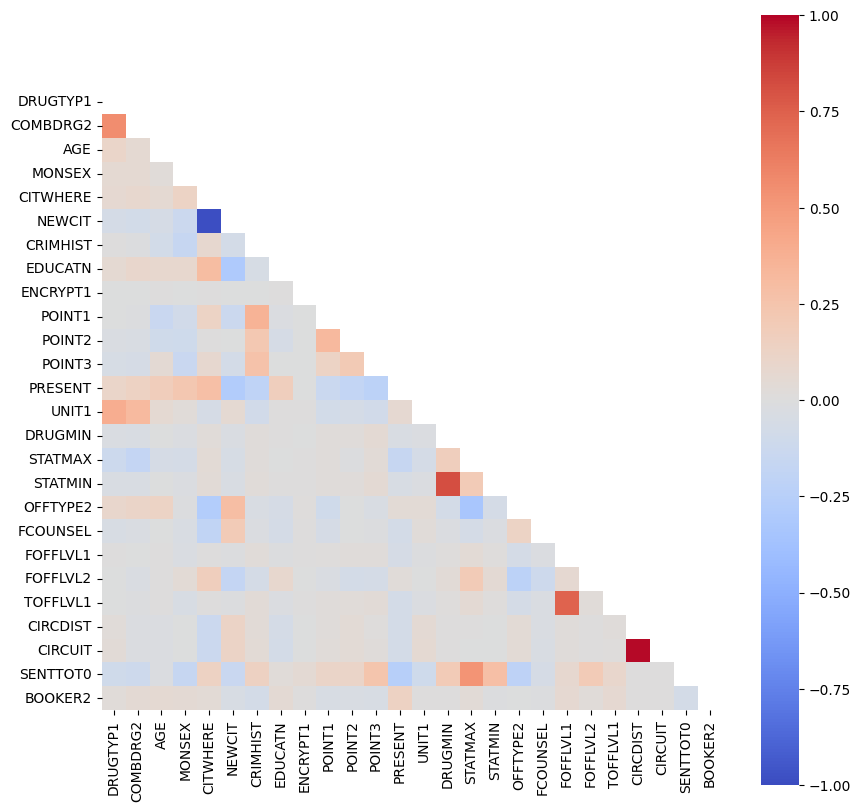

In [26]:
correlation_graph(justfair[charging_predictors + hearing_predictors + ['SENTTOT0', 'BOOKER2']])

## Scaling, label encoding, imputing

In [27]:
#Once again, take sample to get back to original data
random.seed(1)
train_set_sampled = train_set.sample(n=10000)
train_set_sampled.dropna(subset=['SENTTOT0'], inplace=True)

#Subset it, and select predictor and target variables:
X_train_set_sampled = train_set_sampled[all_predictors]
y_train_set_sampled_SENTTOT0 = train_set_sampled['SENTTOT0']
y_train_set_sampled_BOOKER2 = train_set_sampled['BOOKER2']

X_validation_set = validation_set[all_predictors]

In [28]:
def scale_data_minmax(df, categorical_features, origin_df):
    numerical_features = list(set(all_predictors) - set(categorical_features))
    scaler = MinMaxScaler()
    scaler.fit(origin_df[numerical_features]) # Fit the imputer on the numeric features of the training data only
    df_scaled = pd.DataFrame(scaler.transform(df[numerical_features]), columns=numerical_features) # Transform new data with values from the origin_df
    df.update(df_scaled)

    return df

def impute_data(df, categorical_features, origin_df):
    numerical_features = list(set(df.columns) - set(categorical_features))

    imputer = SimpleImputer(strategy='median')
    imputer.fit(origin_df[numerical_features])
    df[numerical_features] = imputer.transform(df[numerical_features])

    mode_values = origin_df[categorical_features].mode().iloc[0]
    df[categorical_features] = df[categorical_features].fillna(mode_values)
    
    return df

def label_encode(df, categorical_features):
    le = LabelEncoder()
    for feature in categorical_features:
        df[feature] = le.fit_transform(df[feature])
    return df

In [29]:
def preprocess_data(df, categorical_features, origin_df):
    
    # FJC data encodes NAs as -8, so correct that by recoding as -8
    df = df.replace(-8, np.nan)
    df = df.replace('-8', np.nan)
    
    df = scale_data_minmax(df, categorical_features, origin_df)
    
    df[all_predictors_categorical] = df[all_predictors_categorical].astype(str)
    df = label_encode(df, categorical_features)

    df = impute_data(df, categorical_features, origin_df)

    return df

In [30]:
preprocess_data(X_train_set_sampled, all_predictors_categorical, X_train_set_sampled)
#preprocess_data(X_validation_set, all_predictors_categorical, X_train_set_sampled)

,DRUGTYP1,COMBDRG2,NEWRACE,AGE,MONSEX,CITWHERE,NEWCIT,CRIMHIST,EDUCATN,ENCRYPT1,...,HOMDUM,HRCOMSRV,NOCOMP,NOCOUNTS,PRISDUM,TOTCHPTS,WEAPON,VIOL1PTS,ADJOFL1,ADJOFLHI
568281,30,1,0,26.0,0.0,36,0,1,2,0,...,0,0.0,1.0,1.0,1,13.0,0,0.0,21,21
65467,40,6,2,47.0,0.0,36,0,0,3,0,...,1,0.0,1.0,1.0,0,0.0,0,0.0,4,4
98014,40,6,0,45.0,0.0,79,1,1,25,0,...,0,0.0,1.0,1.0,1,0.0,0,0.0,5,5
34227,40,6,0,45.0,0.0,36,0,1,18,0,...,0,0.0,2.0,2.0,1,5.0,0,0.0,1,1
160203,40,6,0,26.0,0.0,36,0,0,10,0,...,0,0.0,1.0,1.0,1,0.0,0,0.0,16,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577785,38,5,3,57.0,0.0,36,0,1,13,0,...,0,0.0,1.0,2.0,1,6.0,0,0.0,4,4
513698,40,6,3,26.0,0.0,36,0,1,25,0,...,0,0.0,1.0,1.0,1,18.0,0,0.0,4,4
511052,10,5,0,30.0,0.0,36,0,1,18,0,...,0,0.0,1.0,1.0,0,0.0,0,0.0,0,0
153070,0,0,0,36.0,0.0,36,0,1,1,0,...,0,0.0,1.0,1.0,1,1.0,0,0.0,16,16


## Evaluation metric: RMSE

I considered the following evaluation metrics:

 - MAE: Mean Absolute Error - lower values indicate better performance. A MAE of 15 would mean that an average error is 15 months.
 - MSE: Mean Squared Error - lower values also mean better performance, but larger errors matter more.
 - RMSE: Root Mean Squared Error - Penalizes large errors even more than MSE. Also, it is measured in the same units as the response variable.
 - R2: Familiar from linear regression, this explains how much percentage-wise of variance the model explains.

I want to penalize errors of large magnitudes, so the choice is RMSE. 

RMSE is sensitive to outliers, and I want to be as informed of those as possible.

#### Booker Categories

If I also predict `BOOKER2`, I will use F1 as an evaluation metric, since it balances precision and recall.


## Model selection

In [31]:
#Once again, take sample to get back to original data
random.seed(1)
train_set_sampled = train_set.sample(n=10000)
train_set_sampled.dropna(subset=['SENTTOT0'], inplace=True)

#Subset it, and select predictor and target variables:
X_train_set_sampled = train_set_sampled[all_predictors]
y_train_set_sampled_SENTTOT0 = train_set_sampled['SENTTOT0']
y_train_set_sampled_BOOKER2 = train_set_sampled['BOOKER2']

In the next steps, I will be reviewing these models from the [ISLR](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf) textbook:

**Chapter 3: K-Nearest Neighbors**


knn_regressor = `KNeighborsRegressor()`

rf_regressor = `RandomForestRegressor()`

**Chapter 6: Shrinkage methods**

ridge_regressor = `Ridge() `
lasso_regressor = `Lasso()`

**Chapter 10: Stochastic Gradual Descent**

gbrt_regressor = `GradientBoostingRegressor() `

**Chapters 8, 9, 10: Non-Linear Methods**

gbm_regressor = `xgb.XGBRegressor() `

In [32]:
X_train_set_sampled_processed = preprocess_data(X_train_set_sampled, all_predictors_categorical, X_train_set_sampled)

### K-Nearest Neighbors

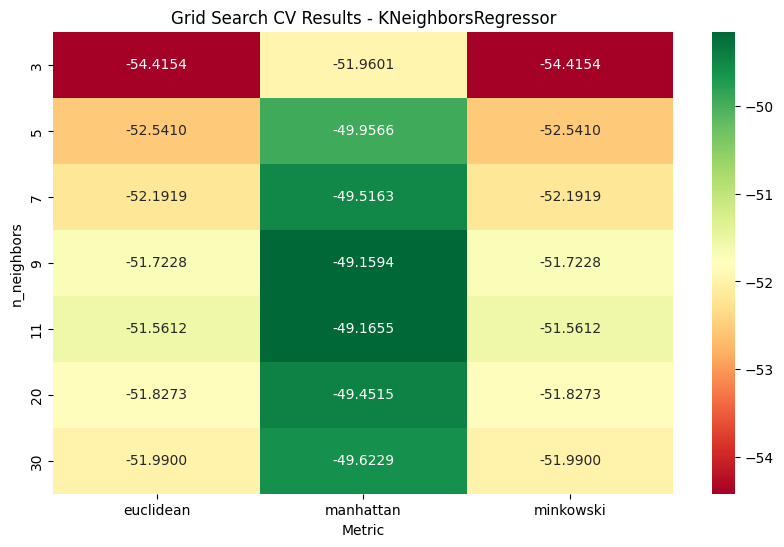

In [33]:
#GridSearchCV always tries to maximize its score, so loss functions like MSE have to be negated
# The actual value I am getting is the positive verson of RMSE.

# Define the range of values for n_neighbors and metric
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 20, 30],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create the KNeighborsRegressor and GridSearchCV objects
knn_regressor = KNeighborsRegressor()
knn_grid = GridSearchCV(knn_regressor, param_grid, scoring='neg_root_mean_squared_error', cv=5)

# Fit the GridSearchCV object
knn_grid.fit(X_train_set_sampled_processed, y_train_set_sampled_SENTTOT0)

# Convert the CV results to a pandas DataFrame
cv_results = pd.DataFrame(knn_grid.cv_results_)

# Pivot the DataFrame to create a heatmap
heatmap_data = cv_results.pivot(index='param_n_neighbors', columns='param_metric', values='mean_test_score')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='RdYlGn')
plt.title('Grid Search CV Results - KNeighborsRegressor')
plt.xlabel('Metric')
plt.ylabel('n_neighbors')
plt.show()


In [34]:
# Accessing the CV results for KNeighborsRegressor
knn_cv_results = knn_grid.cv_results_
knn_mean_scores = knn_cv_results['mean_test_score']
knn_params = knn_cv_results['params']

# Finding the best hyperparameter configuration for KNeighborsRegressor
best_knn_score = max(knn_mean_scores)
best_knn_params = knn_params[knn_mean_scores.argmax()]
best_knn_params

{'metric': 'manhattan', 'n_neighbors': 9}

### Random Forest

In [35]:
# RandomForestRegressor hyperparameter tuning
rf_regressor = RandomForestRegressor()
rf_params = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [None, 5, 10],
    'max_features': ['auto', 'sqrt']
}
rf_grid = GridSearchCV(rf_regressor, rf_params, scoring='neg_root_mean_squared_error', cv=5)
rf_grid.fit(X_train_set_sampled_processed, y_train_set_sampled_SENTTOT0)

KeyboardInterrupt: 

In [ ]:
# Accessing the CV results for RandomForestRegressor
rf_cv_results = rf_grid.cv_results_
rf_mean_scores = rf_cv_results['mean_test_score']
rf_params = rf_cv_results['params']

# Finding the best hyperparameter configuration for RandomForestRegressor
best_rf_score = max(rf_mean_scores)
best_rf_params = rf_params[rf_mean_scores.argmax()]

In [ ]:
best_rf_score

In [ ]:
best_rf_params

### Ridge, Lasso

In [ ]:
# Ridge hyperparameter tuning
ridge_regressor = Ridge()
ridge_params = {
    'alpha': [0.1, 1.0, 10.0]  # Example range of values for alpha
}
ridge_grid = GridSearchCV(ridge_regressor, ridge_params, scoring='neg_root_mean_squared_error', cv=5)
ridge_grid.fit(X_train_set_sampled_processed, y_train_set_sampled_SENTTOT0)

# Lasso hyperparameter tuning
lasso_regressor = Lasso()
lasso_params = {
    'alpha': [0.1, 1.0, 10.0]  # Example range of values for alpha
}
lasso_grid = GridSearchCV(lasso_regressor, lasso_params, scoring='neg_root_mean_squared_error', cv=5)
lasso_grid.fit(X_train_set_sampled_processed, y_train_set_sampled_SENTTOT0)

In [ ]:
# Accessing the CV results for Ridge
ridge_cv_results = ridge_grid.cv_results_
ridge_mean_scores = ridge_cv_results['mean_test_score']
ridge_params = ridge_cv_results['params']

# Finding the best hyperparameter configuration for Ridge
best_ridge_score = max(ridge_mean_scores)
best_ridge_params = ridge_params[ridge_mean_scores.argmax()]

# Accessing the CV results for Lasso
lasso_cv_results = lasso_grid.cv_results_
lasso_mean_scores = lasso_cv_results['mean_test_score']
lasso_params = lasso_cv_results['params']

# Finding the best hyperparameter configuration for Lasso
best_lasso_score = max(lasso_mean_scores)
best_lasso_params = lasso_params[lasso_mean_scores.argmax()]

In [ ]:
best_ridge_score

In [ ]:
best_lasso_score

## Bagging, Boosting

#### Gradient Boosting

In [ ]:
# GradientBoostingRegressor hyperparameter tuning
gbrt_regressor = GradientBoostingRegressor()
gbrt_params = {
    'n_estimators': [100, 200, 300],  # Example range of values for n_estimators
    'learning_rate': [0.1, 0.01, 0.001],  # Example range of values for learning_rate
    'max_depth': [3, 5, 7]  # Example range of values for max_depth
}
gbrt_grid = GridSearchCV(gbrt_regressor, gbrt_params, scoring='neg_root_mean_squared_error', cv=5)
gbrt_grid.fit(X_train_set_sampled_processed, y_train_set_sampled_SENTTOT0)

In [ ]:
# Accessing the CV results for GradientBoostingRegressor
gbrt_cv_results = gbrt_grid.cv_results_
gbrt_mean_scores = gbrt_cv_results['mean_test_score']
gbrt_params = gbrt_cv_results['params']

# Finding the best hyperparameter configuration for GradientBoostingRegressor
best_gbrt_score = max(gbrt_mean_scores)
best_gbrt_params = gbrt_params[gbrt_mean_scores.argmax()]

In [ ]:
best_gbrt_score

In [ ]:
best_gbrt_params

### XGBoost

In [ ]:
# XGBRegressor hyperparameter tuning
gbm_regressor = xgb.XGBRegressor()
gbm_params = {
    'n_estimators': [100, 150, 200, 250],  # Example range of values for n_estimators
    'learning_rate': [.5, 0.1, 0.01, 0.001],  # Example range of values for learning_rate
    'max_depth': [4, 5, 6, 7]  # Example range of values for max_depth
}
gbm_grid = GridSearchCV(gbm_regressor, gbm_params, scoring='neg_root_mean_squared_error', cv=5)
gbm_grid.fit(X_train_set_sampled_processed, y_train_set_sampled_SENTTOT0)

In [ ]:
# Accessing the CV results for XGBRegressor
gbm_cv_results = gbm_grid.cv_results_
gbm_mean_scores = gbm_cv_results['mean_test_score']
gbm_params = gbm_cv_results['params']

# Finding the best hyperparameter configuration for XGBRegressor
best_gbm_score = max(gbm_mean_scores)
best_gbm_params = gbm_params[gbm_mean_scores.argmax()]

In [ ]:
best_gbm_score

In [ ]:
best_gbm_params

Let's see those all in one place:

In [ ]:
print("KNeighborsRegressor:")
print("Best Score:", best_knn_score)
print("Best Parameters:", best_knn_params)
print()

print("RandomForestRegressor:")
print("Best Score:", best_rf_score)
print("Best Parameters:", best_rf_params)
print()

print("Ridge:")
print("Best Score:", best_ridge_score)
print("Best Parameters:", best_ridge_params)
print()

print("Lasso:")
print("Best Score:", best_lasso_score)
print("Best Parameters:", best_lasso_params)
print()

print("GradientBoostingRegressor:")
print("Best Score:", best_gbrt_score)
print("Best Parameters:", best_gbrt_params)
print()

print("XGBRegressor:")
print("Best Score:", best_gbm_score)
print("Best Parameters:", best_gbm_params)
print()


### Bringing it together

Since `SENTTOT0` can assume the value of 0, I am assuming NaN values are missing at random. This could be false, but only 5% are missing so it may not impact my analysis. Therefore I drop rows that have no `SENTTOT0` before continuing:

In [ ]:
# split data into train and validation sets
train_set, validation_set = train_test_split(justfair, test_size=0.3, random_state=1)
train_set.dropna(subset=['SENTTOT0'], inplace=True)
validation_set.dropna(subset=['SENTTOT0'], inplace=True)


#Subset it, and select predictor and target variables:
X_train_set = train_set[all_predictors]
y_train_set_SENTTOT0 = train_set['SENTTOT0']
y_train_set_BOOKER2 = train_set['BOOKER2']

X_validation_set = validation_set[all_predictors]
y_validation_set_SENTTOT0 = validation_set['SENTTOT0']
y_validation_set_BOOKER2 = validation_set['BOOKER2']

And select the hyperparameters that were chosen by GridSearchCV previously:

In [ ]:
gbm_params = {'n_estimators': 150, 
              'learning_rate': 0.1, 
              'max_depth': 6}

gbm_regressor = xgb.XGBRegressor(**gbm_params)

Here, I fit the model on all training data (after pre-processing):

In [ ]:
X_train_set = preprocess_data(X_train_set, all_predictors_categorical, X_train_set)

gbm_regressor.fit(X_train_set, y_train_set_SENTTOT0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

And before I make actual predictions, I must also preprocess the validation set data, using imputations and values from the training set:

In [ ]:
#Preprocess the data with information from the training set
X_validation_set = preprocess_data(X_validation_set, all_predictors_categorical, X_train_set)

#Make predictions on the validation set
y_pred = gbm_regressor.predict(X_validation_set[all_predictors])

Finally we have some predictions. How did we do?

In [ ]:
rmse = np.sqrt(mean_squared_error(y_validation_set_SENTTOT0, y_pred))
rmse

38.21505815238171

### Predictions at time of charging

Part of this project was to set aside certain predictors for when they would be available in real life. 

In [ ]:
#Preprocess the data with information from the training set
X_validation_set = preprocess_data(X_validation_set, charging_predictors, X_train_set)

# Fit the model on all training data
X_train_set = preprocess_data(X_train_set, charging_predictors, X_train_set)

In [ ]:
gbm_regressor.fit(X_train_set[charging_predictors], y_train_set_SENTTOT0)

#Make predictions on the validation set
y_pred = gbm_regressor.predict(X_validation_set[charging_predictors])

### Predictions at time of arraignment

In [ ]:
gbm_regressor.fit(X_train_set[charging_predictors + hearing_predictors], y_train_set_SENTTOT0)

#Make predictions on the validation set
y_pred = gbm_regressor.predict(X_validation_set[charging_predictors + hearing_predictors])

In [ ]:
rmse = np.sqrt(mean_squared_error(y_validation_set_SENTTOT0, y_pred))
rmse

58.16223320639707

### Predictions at time of plea bargain

In [ ]:
gbm_regressor.fit(X_train_set[charging_predictors + hearing_predictors + plea_predictors], y_train_set_SENTTOT0)

#Make predictions on the validation set
y_pred = gbm_regressor.predict(X_validation_set[charging_predictors + hearing_predictors + plea_predictors])

In [ ]:
rmse = np.sqrt(mean_squared_error(y_validation_set_SENTTOT0, y_pred))
rmse

57.67004524865655

#### Feature importances

Using all predictors, which one is most important?

In [ ]:
feature_importances = gbm_regressor.feature_importances_

# Sort the feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Print the feature importance ranking
for i, feature_index in enumerate(sorted_indices):
    feature_name = X_train_set[charging_predictors].columns[feature_index]
    importance_score = feature_importances[feature_index]
    print(f"Rank {i+1}: {feature_name} ({importance_score})")

#### `BOOKER2`: predicting sentencing departures

In [ ]:
#Percentage of NaNs in y_train_set_BOOKER2: 35.90%

#Provide justification for dropping NAs in y_train
nan_count = y_train_set_BOOKER2.isna().sum()
total_samples = len(y_train_set_BOOKER2)

nan_percentage = (nan_count / total_samples) * 100
print("Percentage of NaNs in y_train_set_BOOKER2: {:.2f}%".format(nan_percentage))

Percentage of NaNs in y_train_set_BOOKER2: 35.90%


In [ ]:
# Take a sample, and remove rows that have no booker category.
#Once again, take sample to get back to original data
random.seed(1)
train_set_sampled = train_set.sample(n=10000)
train_set_sampled.dropna(subset=['BOOKER2'], inplace=True)

#Subset it, and select predictor and target variables:
X_train_set_sampled = train_set_sampled[all_predictors]
y_train_set_sampled_BOOKER2 = train_set_sampled['BOOKER2']

#### Another GridSearch

Since Booker category is categorical unlike `SENTTOT0`, I need to use a different model (XGBClassifier vs XGBRegressor) and also do another bout of hyperparameter tuning.

In [ ]:
# Need to preprocess sampled data before GridSearchCV
X_train_set_sampled = preprocess_data(X_train_set_sampled, all_predictors_categorical, X_train_set_sampled)

In [ ]:
gbm_classifier = xgb.XGBClassifier()
gbm_classifier_params = {
    'n_estimators': [100, 150, 200, 250],  # Example range of values for n_estimators
    'learning_rate': [.5, 0.1, 0.01, 0.001],  # Example range of values for learning_rate
    'max_depth': [4, 5, 6, 7]  # Example range of values for max_depth
}
gbm_grid = GridSearchCV(gbm_classifier, gbm_classifier_params, scoring='neg_root_mean_squared_error', cv=5)
gbm_grid.fit(X_train_set_sampled, y_train_set_sampled_BOOKER2)

In [ ]:
# Accessing the CV results for XGBClassifier
gbm_cv_results = gbm_grid.cv_results_
gbm_mean_scores = gbm_cv_results['mean_test_score']
gbm_params = gbm_cv_results['params']

# Finding the best hyperparameter configuration for XGBClassifier
best_gbm_score = max(gbm_mean_scores)
best_gbm_params = gbm_params[gbm_mean_scores.argmax()]

In [ ]:
best_gbm_score

In [ ]:
best_gbm_params

OK, those parameters are what I'll choose:

In [ ]:
gbm_classifier_params = {'n_estimators': 250, 
              'learning_rate': 0.1, 
              'max_depth': 4}

gbm_classifier = xgb.XGBClassifier(**gbm_classifier_params)

Let's fit with all the data now, dropping rows where the `BOOKER2` value does not exist:

In [ ]:
train_set, validation_set = train_test_split(justfair, test_size=0.3, random_state=1)
train_set.dropna(subset=['BOOKER2'], inplace=True)
validation_set.dropna(subset=['BOOKER2'], inplace=True)

#Subset it, and select predictor and target variables:
X_train_set = train_set[all_predictors]
y_train_set_BOOKER2 = train_set['BOOKER2']

X_validation_set = validation_set[all_predictors]
y_validation_set_BOOKER2 = validation_set['BOOKER2']

The data must be preprocessed first:

In [ ]:
X_train_set = preprocess_data(X_train_set, all_predictors_categorical, X_train_set)

In [ ]:
gbm_classifier.fit(X_train_set, y_train_set_BOOKER2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
X_validation_set = preprocess_data(X_validation_set, all_predictors_categorical, X_train_set)

In [ ]:
y_pred_booker = gbm_classifier.predict(X_validation_set)

In [ ]:
f1 = f1_score(y_validation_set_BOOKER2, y_pred_booker, average='weighted')
print("F1 score:", f1)

F1 score: 0.5788433526172613


### Booker2 classification at the charging stage

In [ ]:
#Preprocess the data with information from the training set
X_validation_set = preprocess_data(X_validation_set, charging_predictors, X_train_set)

X_train_set = preprocess_data(X_train_set, charging_predictors, X_train_set)

In [ ]:
gbm_classifier.fit(X_train_set[charging_predictors], y_train_set_BOOKER2)

#Make predictions on the validation set
y_pred = gbm_classifier.predict(X_validation_set[charging_predictors])

In [ ]:
f1 = f1_score(y_validation_set_BOOKER2, y_pred, average='weighted')
print("F1 score:", f1)

F1 score: 0.39300160213695523


### `Booker2` classification at the arraignment stage

In [ ]:
#Preprocess the data with information from the training set
X_validation_set = preprocess_data(X_validation_set, charging_predictors + hearing_predictors, X_train_set)

X_train_set = preprocess_data(X_train_set, charging_predictors + hearing_predictors, X_train_set)

In [ ]:
gbm_classifier.fit(X_train_set[charging_predictors + hearing_predictors], y_train_set_BOOKER2)

#Make predictions on the validation set
y_pred = gbm_classifier.predict(X_validation_set[charging_predictors + hearing_predictors])

In [ ]:
f1 = f1_score(y_validation_set_BOOKER2, y_pred, average='weighted')
print("F1 score:", f1)

F1 score: 0.38790977221146605


### `Booker2` classification at the plea stage

In [ ]:
#Preprocess the data with information from the training set
X_validation_set = preprocess_data(X_validation_set, charging_predictors + hearing_predictors + plea_predictors, X_train_set)

X_train_set = preprocess_data(X_train_set, charging_predictors + hearing_predictors, X_train_set)

In [ ]:
gbm_classifier.fit(X_train_set[charging_predictors + hearing_predictors + plea_predictors], y_train_set_BOOKER2)

#Make predictions on the validation set
y_pred = gbm_classifier.predict(X_validation_set[charging_predictors + hearing_predictors + plea_predictors])

In [ ]:
f1 = f1_score(y_validation_set_BOOKER2, y_pred, average='weighted')
print("F1 score:", f1)

F1 score: 0.36897322424178874


### Conclusions 

Coming soon to a notebook near you!

In [ ]:

#mapping = {0: 'Within Range',
#           1: 'Above Departure',
#           2: 'Government Sponsored Below Range',
#           3: 'Below Range'}
#
#train_set['BOOKER2'] = train_set['BOOKER2'].replace(mapping)
#validation_set['BOOKER2'] = validation_set['BOOKER2'].replace(mapping)